# Modules


In [ ]:
verbose = 1 # @param {type:"slider", min:0, max:3, step:1}
verbose = min(max(verbose, 0), 3) # clamp to [0, 3]

colab = False
tpu = False
try:
    from google.colab import drive

    colab = True
    drive.mount('/content/drive', force_remount=True)
    drive_dir = "bronte" # @param {type:"string"}
    path = "/".join(["drive", "MyDrive", drive_dir])
    %cd $path

    %pip install torch_xla
    import torch_xla
    import torch_xla.core.xla_model as xm

    tpu = True
except:
    pass

# system
import logging
import os
import subprocess
import sys
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# This will install the packages below. If you use an environment manager, comment this
# out and make sure the packages in requirements.txt are installed in your environment.
if verbose:
    print("Fetching any missing dependencies...")
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed = [r.decode().split('==')[0] for r in reqs.split()]
failure = []
with open("requirements.txt", 'r') as dependencies:
    for pkg in dependencies.readlines(): # to ignore errors
        # if pkg is a comment or empty line
        if pkg.startswith('#') or len(pkg.strip()) == 0:
            continue
        pkg = pkg.strip()
        args = f"pip install {pkg} {' '.join(['-q' for _ in range(3 - verbose)])} --break-system-packages"
        if pkg not in installed and subprocess.call(args.split()) != 0:
            failure.append(pkg)

if len(failure) > 0 and failure[0]:
    print("Failed to install the following packages: " + str(failure))
    print("Try installing them manually.")
    raise SystemExit(1)
elif verbose:
    print("All dependencies are installed.")

warnings.filterwarnings("ignore")

# Preprocessing
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport

# ML
import torch
from torch import nn
from src.main import Bronte

# Parallelization
import joblib
import dask.config as dc
from dask.distributed import Client

levels = [
    'critical',
    'error',
    'warn',
    'info',
]

dc.set({'logging.distributed': levels[verbose]})

Fetching any missing dependencies...
All dependencies are installed.


# ETL Pipeline


## Extraction


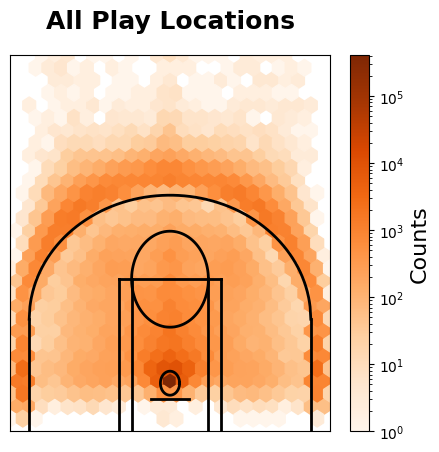

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def load_data_sources(filepaths):
    data = {}
    for name, path_or_paths in filepaths.items():
        if isinstance(path_or_paths, str):  # If it's a single string, read that CSV
            data[name] = [pd.read_csv(path_or_paths)]
        else:  # If it's a list of strings, read each CSV into a list of dataframes
            data[name] = [pd.read_csv(path) for path in path_or_paths]
    return data


def preprocess_aux_data(df):
    if "Player" in df.columns:
        df["playerNameI"] = df["Player"].apply(
            lambda x: x[0] + ". " + " ".join(x.split(" ")[1:])
        )
        df = df.drop("Player", axis=1)
    if "Tm" in df.columns:
        df["teamTricode"] = df["Tm"]
        df = df.drop("Tm", axis=1)
    return df


def merge_main_data(dfs, key):
    main_df = dfs[0]
    for secondary_df in dfs[1:]:
        main_df = pd.merge(main_df, secondary_df, on=key, how="left")
    return main_df


def merge_aux_data(main_df, dfs, key):
    merged_dfs = pd.concat(dfs, ignore_index=True)
    merged_dfs = merged_dfs.drop_duplicates(subset=key)

    merged_main_df = main_df.merge(merged_dfs, on=key, how="left", suffixes=("", "_y"))
    return merged_main_df.drop(
        [col for col in merged_main_df.columns if col.endswith("_y")], axis=1
    )


def plot_court(data, title, path="./", color="black"):
    fig = plt.figure(figsize=(4, 3.76))
    ax = fig.add_axes([0, 0, 1, 1])

    # 3PT lines + Arc
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)
    x = np.linspace(-220, 220, 400)
    ax.plot(x, 140 + (np.sqrt(1 - (x**2 / 220**2)) * 155), linewidth=2, color=color)

    # Lane + Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)

    # Free Throw Circle + Rim + Backboard
    theta = np.linspace(0, 2 * np.pi, 100)
    ax.plot(60 * np.cos(theta), 60 * np.sin(theta) + 190, linewidth=2, color=color)
    ax.plot(15 * np.cos(theta), 15 * np.sin(theta) + 60, linewidth=2, color=color)
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)

    # Remove ticks and set limits
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

    # Plays
    hb = ax.hexbin(
        *(data[0], data[1] + 60),
        gridsize=(30, 30),
        extent=(-300, 300, 0, 940),
        bins="log" if len(data[0]) > 100 else None,
        cmap="Oranges",
    )
    # legend
    cb = plt.colorbar(hb, ax=ax)
    cb.set_label("Counts", fontsize=16)

    # if path/court doesn't exist, create it
    loc = "".join([path, "court/"])
    if not os.path.exists(loc):
        os.makedirs(loc)

    # Title
    plt.title(title, fontsize=18, fontweight="bold", y=1.05)
    plt.savefig("".join([loc, title, ".png"]), dpi=300)
    plt.show()


# Load data
path = "./data/"
filepaths = {"games": ["plays-2022-23.csv"], "players": ["players-2022-23.csv"]}
# prepend path to filepaths, which is a list of lists
data_sources = load_data_sources(
    {
        name: [os.path.join(path, path_or_paths) for path_or_paths in paths]
        for name, paths in filepaths.items()
    }
)

# Ensure sources are loaded
assert len(data_sources) > 0 and all(
    [len(df) > 0 for df_list in data_sources.values() for df in df_list]
)

# Combine sources
df = pd.DataFrame()
main_key = "game_id"
aux_key = ["playerNameI", "teamTricode"]
for name, dfs in data_sources.items():
    dfs = [preprocess_aux_data(df) for df in dfs]
    if name == "games":
        df = merge_main_data(dfs, main_key)
    else:
        df = merge_aux_data(df, dfs, aux_key)

# EDA
plot_court((df["xLegacy"], df["yLegacy"]), "All Play Locations", path)

profile = ProfileReport(df, explorative=True)
profile.to_file("".join([path, "profile.html"]))

if colab:
    profile.to_notebook_iframe()
else:
    profile.to_widgets()

## Transformation


### Cleaning


In [ ]:
# Keep columns that contain at least one letter
df = df[[col for col in df.columns if any(char.isalpha() for char in col)]]

# remove unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# remove commas
for col in df.columns:
    if df[col].dtype == "object":
        try:
            df[col] = pd.to_numeric(df[col].str.replace(",", ""))
        except ValueError:
            pass

# Drop rows where player is missing
df = df.dropna(subset=["playerNameI"])

# Update numerical_features and categorical_features lists
numerical_features = df.select_dtypes(include=["number"]).columns.tolist()
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

# Define transformers
numerical_transformers = Pipeline(
    steps=[
        (
            "imputer",
            IterativeImputer(
                estimator=BayesianRidge(),
                # max_iter=25,
                random_state=42,
                sample_posterior=True,
                skip_complete=True,
                n_nearest_features=max(len(numerical_features) // 5, 5),
            ),
        )
    ]
)

categorical_transformers = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent"))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformers, numerical_features),
        ("cat", categorical_transformers, categorical_features),
    ]
)

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Apply the transformations
client = Client(n_workers=os.cpu_count())
with joblib.parallel_backend("dask"):
    df = pd.DataFrame(
        pipeline.fit_transform(df), columns=numerical_features + categorical_features
    )
client.close()

# Drop rows with missing or duplicate values
df = df.dropna()
df = df.drop_duplicates()

df.head()

,period,scoreHome,scoreAway,xLegacy,yLegacy,shotDistance,isFieldGoal,shotVal,scoreVal,Rk,...,home,away,playerNameI,teamTricode,description,actionType,subType,location,Pos,Player-additional
0,1.0,10.704005,15.46612,0.0,0.0,0.0,0.0,2.020971,0.630374,340.271141,...,HOU,SAC,A. Sengun,HOU,Jump Ball Sengun vs. Sabonis: Tip to Huerter,Jump Ball,Unknown,h,SG,antetgi01
1,1.0,0.0,2.0,-9.0,53.0,5.0,1.0,2.0,2.0,428.0,...,HOU,SAC,D. Sabonis,SAC,Sabonis 5' Turnaround Hook Shot (2 PTS) (Huert...,Made Shot,Turnaround Hook Shot,v,C,sabondo01
2,1.0,9.945005,25.547078,25.0,86.0,9.0,1.0,2.0,0.0,177.0,...,HOU,SAC,J. Green,HOU,MISS Green 9' Driving Floating Bank Jump Shot,Missed Shot,Driving Floating Bank Jump Shot,h,SG,greenja05
3,1.0,-8.505627,-11.304633,0.0,0.0,0.0,0.0,2.440331,1.58787,311.0,...,HOU,SAC,K. Martin Jr.,HOU,Martin Jr. REBOUND (Off:1 Def:0),Rebound,Unknown,h,SF,martike04
4,1.0,2.0,2.0,23.0,17.0,3.0,1.0,2.0,2.0,311.0,...,HOU,SAC,K. Martin Jr.,HOU,Martin Jr. 3' Putback Layup (2 PTS),Made Shot,Putback Layup Shot,h,SF,martike04


### Feature Engineering


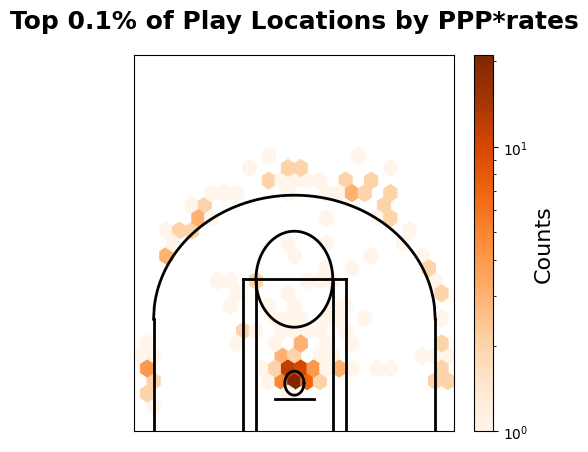

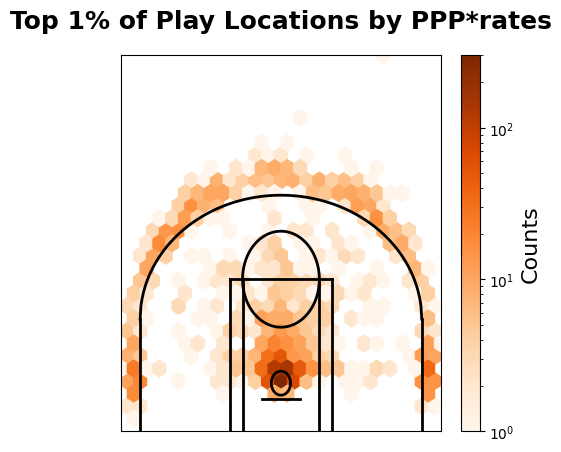

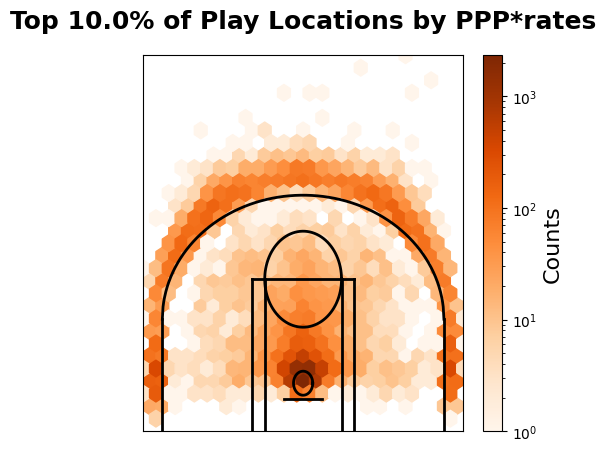

In [ ]:
if "clock" in df.columns:
    # Let's convert the clock str to number of seconds
    minute = df["clock"].apply(lambda x: int(x.split(":")[0]))
    second = df["clock"].apply(lambda x: float(x.split(":")[1]))
    time = minute * 60 + second
    df["time"] = max(time) - time  # this reverses the clock so that it counts up

# Create new columns for various checks
df["is_rebound"] = df["actionType"] == "Rebound"
df["is_field_goal_attempt"] = df["isFieldGoal"] == 1

# Calculate shifted columns in one go to reduce redundant operations
df_next = df[["teamTricode", "is_rebound", "is_field_goal_attempt", "time"]].shift(-1)
df_next_next = df[["teamTricode", "is_field_goal_attempt", "time"]].shift(-2)

# Create conditions for better readability
df["led_to_off_rebound"] = (
    df_next["is_rebound"] & (df_next["teamTricode"] == df["teamTricode"])
) & (df["is_field_goal_attempt"] & (df["scoreVal"] == 0))

df["led_to_transition_opp"] = (
    df_next_next["is_field_goal_attempt"]
    & (df_next_next["teamTricode"] != df["teamTricode"])
    & ((df_next_next["time"] - df["time"]) <= 5)
) & (df["is_field_goal_attempt"] & (df["scoreVal"] == 0))

del df_next
del df_next_next

# Handle the last play of the game
df.loc[
    df["teamTricode"].shift(-1).isnull(),
    ["led_to_off_rebound", "led_to_transition_opp"],
] = False

# Define aggregation functions
agg_funcs = {
    "num_shots": ("is_field_goal_attempt", "sum"),
    "num_made": ("scoreVal", "sum"),
    "num_off_rebounds": ("led_to_off_rebound", "sum"),
    "num_transition_opps": ("led_to_transition_opp", "sum"),
}

# Apply aggregation functions
for col_agg, (col, func) in agg_funcs.items():
    df[col_agg] = df.groupby(["xLegacy", "yLegacy"])[col].transform(func)

# Calculate total possessions for each player
df["Possessions"] = df["FGA"] + 0.44 * df["FTA"] - df["ORB"] + df["TOV"]

# Create a column to track turnovers that led to live ball situations
df["is_turnover"] = (df["actionType"] == "Turnover") & df["led_to_transition_opp"]

# Group by playerNameI and calculate turnovers
turnovers = (
    df.groupby("playerNameI")
    .agg(is_turnover_live_ball=("is_turnover", "sum"), TOV_total=("TOV", "sum"))
    .reset_index()
)

# Merge the turnover data with the main dataframe
df = df.merge(turnovers, on="playerNameI", how="left")

# Calculate the rates
off_rebound_rate = df["num_off_rebounds"] / df["num_shots"]
transition_opp_rate = df["num_transition_opps"] / df["num_shots"]
live_to_rate = df["is_turnover_live_ball"] / df["Possessions"]
dead_to_rate = (df["TOV_total"] - df["is_turnover_live_ball"]) / df["Possessions"]
shot_rate = df["num_made"] / df["num_shots"]

PPP = df["scoreVal"] / df["Possessions"]
rates = off_rebound_rate + dead_to_rate - transition_opp_rate - live_to_rate
df["PPP*rates"] = PPP * rates

cols_to_remove = [
    "is_rebound",
    "is_turnover",
    "is_field_goal_attempt",
    "led_to_off_rebound",
    "led_to_transition_opp",
    "clock",
    "num_shots",
    "num_made",
    "num_off_rebounds",
    "num_transition_opps",
    "Possessions",
    "description",
    "is_turnover_live_ball",
    "TOV_total",
    "Player-additional",
]

# Drop the listed columns
df.drop(columns=cols_to_remove, inplace=True, errors="ignore")

# Coerce scoreVal to int
df["scoreVal"] = df["scoreVal"].astype(float).round().astype(int)

# Plot the top plays by PPP*rates
for percent in [1e-1, 1, 1e1]:
    for col in ["PPP*rates"]:
        filtered = df[df["xLegacy"] != 0]
        filtered = filtered[filtered["yLegacy"] != 0]
        sorted = filtered.sort_values(by=col, ascending=False).reset_index(drop=True)
        sorted["rank"] = (sorted.index + 1) / len(sorted) * 100
        sorted = sorted[sorted["rank"] <= percent]
        plot_court(
            (sorted["xLegacy"], sorted["yLegacy"]),
            f"Top {percent}% of Play Locations by {col}",
            path,
        )

## Loading


In [ ]:
db = sqlite3.connect("".join([path, "data.db"]))
prefix = "bronte_"

# clear database
cursor = db.cursor()
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    cursor.execute(f"DROP TABLE {row[0]}")

unique_keys = df[main_key].unique()

# Split game IDs into chunks of size 8
chunk_size = 8  # roughly 4000 rows per 8 games (500 rows per game)
chunks = [
    unique_keys[i : i + chunk_size] for i in range(0, len(unique_keys), chunk_size)
]

for index, chunk in enumerate(chunks):
    subset = df[df[main_key].isin(chunk)]
    table_name = f"{prefix}{index}"
    subset.to_sql(table_name, db, if_exists="replace", index=False)

db.close()

# Deep Learning


## Options


### General


In [ ]:
task_options = {}
model_options = {}

# runs
task_options["restart"] = True  # clear checkpoints before training, restarts training
task_options["resume"] = True  # resume from best checkpoint, enables transfer learning

# data
task_options["db_path"] = "data/data.db"
task_options["table_prefix"] = "bronte_"
task_options["timeseries"] = False
task_options["samples"] = 2  # max number of tables to use for training
task_options[
    "sample_size"
] = 0  # fraction of each table to use or number of rows, 0 for all
task_options["max_corr"] = 1.0  # maximum correlation between features
task_options["task"] = ""

# performance
task_options["use_cuda"] = torch.cuda.is_available()
task_options["device"] = (
    "cuda" if task_options["use_cuda"] else xm.xla_device() if tpu else "cpu"
)
task_options["autocast"] = torch.float16 if task_options["use_cuda"] else torch.bfloat16
task_options["n_workers"] = os.cpu_count() or 1
task_options["batch_size"] = 192
task_options["drop_last"] = True  # if smaller
task_options["accumulate"] = 5  # set <=1 to disable gradient accumulation
task_options["use_checkpoint"] = task_options[
    "use_cuda"
]  # checkpoint.checkpoint, not .pt files
task_options["tune_trials"] = (
    1000 if task_options["use_cuda"] else 0
)  # set <=0 to disable tuning
task_options["verbose"] = verbose  # flag
task_options["colab"] = colab  # flag

# hyperparameters
model_options["epochs"] = 10
model_options["lr"] = 2
model_options["patience"] = 0
model_options["factor"] = 0.6
model_options["betas"] = (0.9, 0.75)
model_options["eps"] = 1e-9
model_options["decay"] = 3e-3

# gradient
model_options["norm_clip"] = 1.0  # clip gradient norms at this value
model_options["init_scale"] = 2**16
model_options["growth_factor"] = 2
model_options["backoff_factor"] = 0.5
model_options["growth_interval"] = 2000
model_options["grad_scaling"] = task_options["use_cuda"]  # flag

# transfer learning
task_options["prev"] = []  # list of previous targets (name of base model)
model_options["freeze"] = []  # list of layers to freeze

### Specific


In [ ]:
def dict_copy(orig):
    dup = {}
    for key, value in orig.items():
        try:
            dup[key] = deepcopy(value)
        except:
            dup[key] = value
    return dup


db = sqlite3.connect(task_options["db_path"])
n_cols = pd.read_sql_query(
    f'SELECT COUNT(*) FROM {task_options["table_prefix"]}1', db
).values[0][0]
db.close()

# arch
ffn_opts = dict_copy(model_options)
ffn_opts["arch"] = "ffn"
ffn_opts["fc_layers"] = [n_cols * 2 // 3] * 3
ffn_opts["fc_dropout"] = np.repeat(0.5, len(ffn_opts["fc_layers"]))

rnn_opts = dict_copy(model_options)
rnn_opts["arch"] = "rnn"
rnn_opts["fc_layers"] = [n_cols * 2 // 3] * 3
rnn_opts["fc_dropout"] = np.repeat(0.5, len(rnn_opts["fc_layers"]))
rnn_opts["rnn_layers"] = 2
rnn_opts["rnn_dropout"] = 0.8
rnn_opts["rnn_type"] = "GRU"  # 'GRU' (or 'LSTM', a bit buggy)
rnn_opts["rnn_seq_len"] = 128
rnn_opts["rnn_bidi"] = True  # task_options["timeseries"]
rnn_opts["attention"] = "concat"  # 'dot', 'general', or 'concat', or None

# task
reg_opts = dict_copy(task_options)
reg_opts["task"] = "reg"
reg_opts["criterion"] = nn.HuberLoss(reduction="none")
reg_opts["targets"] = ["PPP*rates"]

class_opts = dict_copy(task_options)
class_opts["task"] = "class"
class_opts["criterion"] = nn.CrossEntropyLoss(reduction="none")
class_opts["targets"] = ["scoreVal"]
class_opts["max_clusters"] = 4  # max number of classes

# multi-task
multi_reg_opts = dict_copy(reg_opts)
multi_reg_opts["targets"].append("scoreVal")

multi_class_opts = dict_copy(class_opts)
multi_class_opts["targets"].append("PPP*rates")

# fine-tune
fine_reg_opts = dict_copy(reg_opts)
fine_reg_opts["targets"] = ["scoreVal"]
fine_reg_opts["prev"].append(reg_opts["targets"])

fine_class_opts = dict_copy(class_opts)
fine_class_opts["targets"] = ["PPP*rates"]
fine_class_opts["prev"].append(class_opts["targets"])

models = {
    "tasks": {
        "single": [
            # reg_opts,  # single-input/single-output
            class_opts,  # single-input/multi-output
        ],
        "multi": [
            # multi_reg_opts,  # multi-input/single-output
            # multi_class_opts,  # multi-input/multi-output
        ],
        "fine": [
            # fine_reg_opts,
            # fine_class_opts,
        ],
    },
    "archs": [
        ffn_opts,
        # rnn_opts
    ],
}

## Training


Dask dashboard is available at http://127.0.0.1:8787/status

Splitting data and transforming features...
Training a new class ffn model to predict ['scoreVal']...


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 0
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2038.852705522017
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1913.2266438802083
Loss decreased; saving model...

Epoch 1
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2031.5558638139205
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1910.5232747395833
Loss decreased; saving model...

Epoch 2
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2025.3513738458807
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1911.8142903645833
Epoch 00002: reducing learning rate of group 0 to 1.2000e+00.

Epoch 3
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2048.662919477983
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1926.4608154296875
Epoch 00003: reducing learning rate of group 0 to 7.2000e-01.

Epoch 4
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2037.9798473011363
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1945.0157470703125
Epoch 00004: reducing learning rate of group 0 to 4.3200e-01.

Epoch 5
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2027.8623157848012
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1964.6010335286458
Epoch 00005: reducing learning rate of group 0 to 2.5920e-01.

Epoch 6
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2033.118807705966
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1976.181396484375
Epoch 00006: reducing learning rate of group 0 to 1.5552e-01.

Epoch 7
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2029.6993408203125
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1976.2469075520833
Epoch 00007: reducing learning rate of group 0 to 9.3312e-02.

Epoch 8
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2031.8724365234375
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1982.1959228515625
Epoch 00008: reducing learning rate of group 0 to 5.5987e-02.

Epoch 9
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2035.01171875
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1984.2642415364583
Epoch 00009: reducing learning rate of group 0 to 3.3592e-02.

Best: Epoch 1
--------
Testing...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 2032.570068359375

Performance of class ffn model for scoreVal:
	Accuracy: 0.2465277761220932
	F1 Score: 0.17692860960960388
	Precision: 0.4305562674999237
	Recall: 0.2670888900756836
	Area Under ROC Curve: 0.48955899477005005


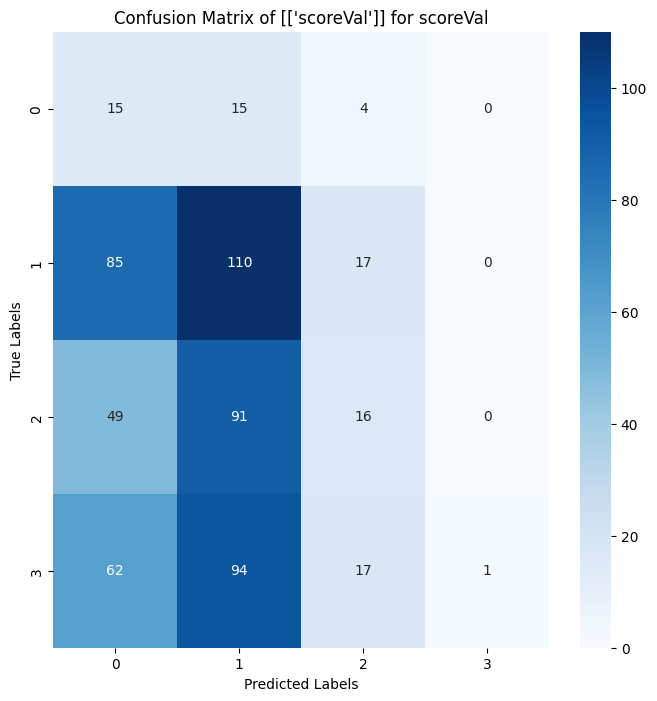

Calculating SHAP values...


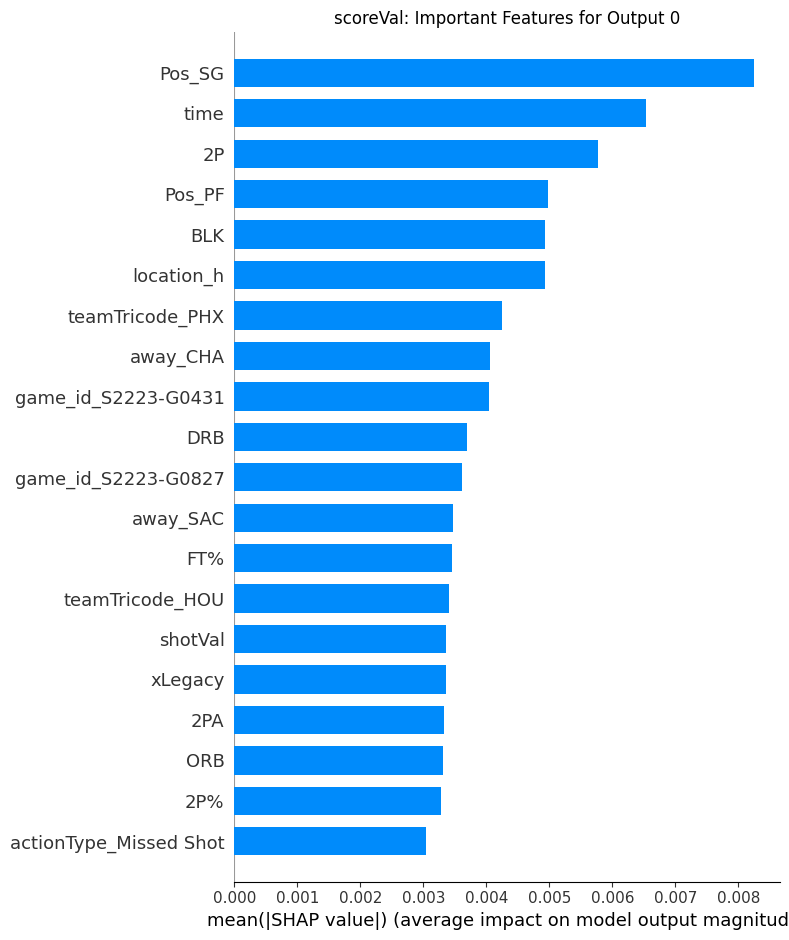

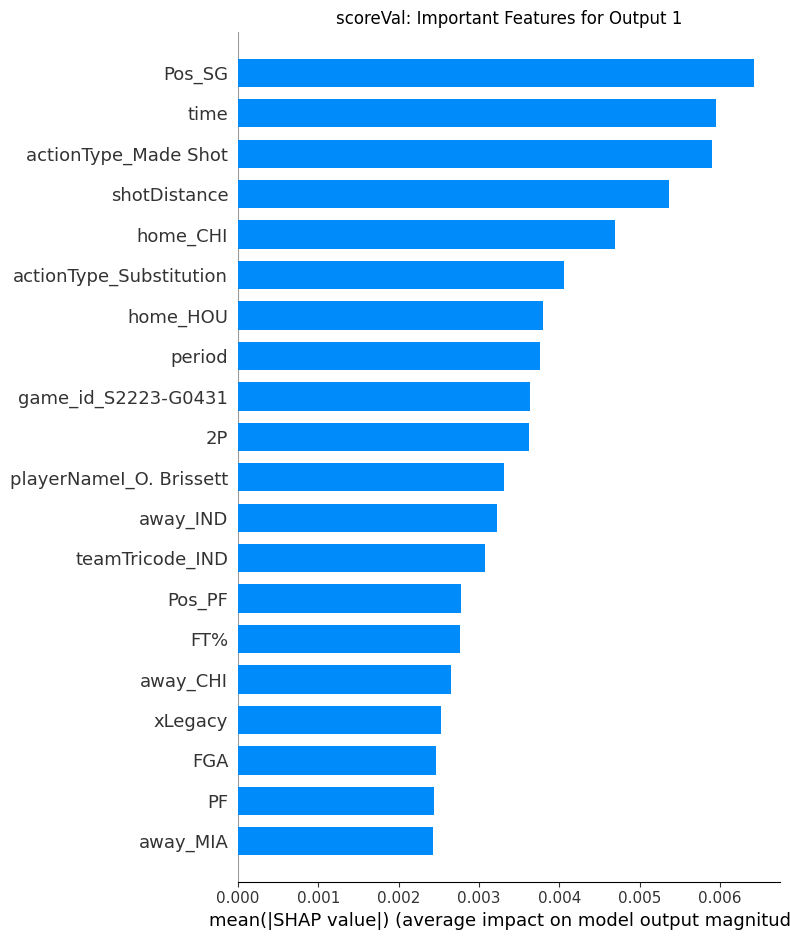

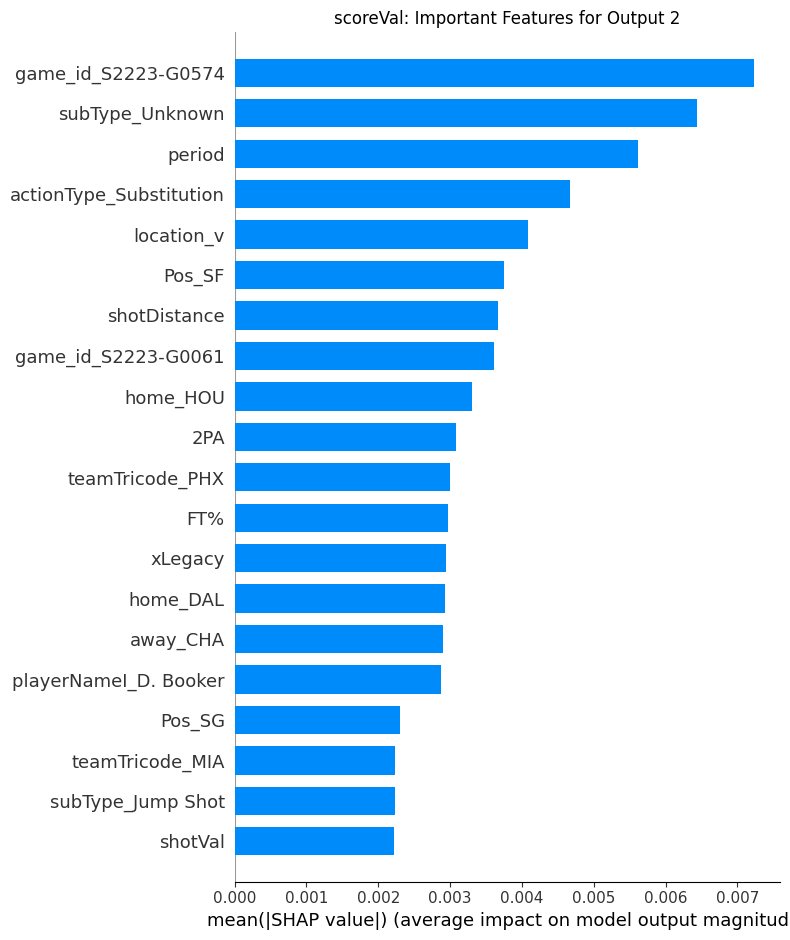

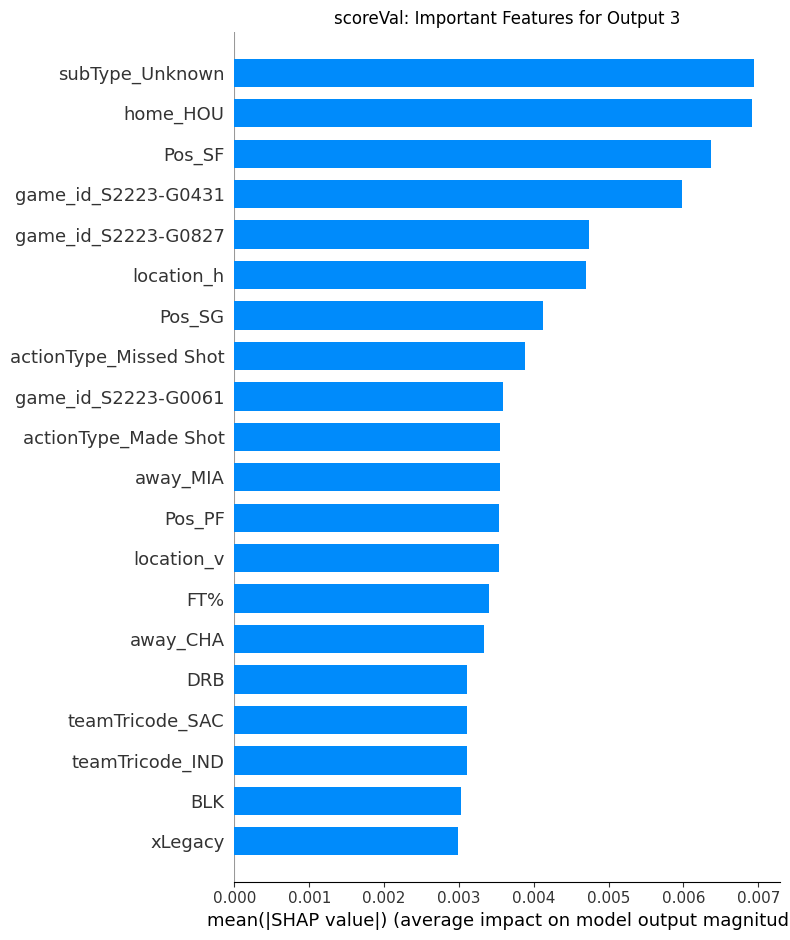


Splitting data and transforming features...
Resuming Training ['scoreVal'] class ffn model to predict ['scoreVal']...


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2009.3372580788352
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1843.052734375
Loss decreased; saving model...

Epoch 3
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2021.6586470170455
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1844.5120442708333
Epoch 00003: reducing learning rate of group 0 to 1.2000e+00.

Epoch 4
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2015.6300048828125
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1855.2809244791667
Epoch 00004: reducing learning rate of group 0 to 7.2000e-01.

Epoch 5
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2010.431795987216
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1871.9908447265625
Epoch 00005: reducing learning rate of group 0 to 4.3200e-01.

Epoch 6
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2014.1488813920455
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1890.458740234375
Epoch 00006: reducing learning rate of group 0 to 2.5920e-01.

Epoch 7
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2019.0847611860795
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1905.16748046875
Epoch 00007: reducing learning rate of group 0 to 1.5552e-01.

Epoch 8
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2012.6677911931818
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1917.0229899088542
Epoch 00008: reducing learning rate of group 0 to 9.3312e-02.

Epoch 9
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2018.3770530007102
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1919.3471272786458
Epoch 00009: reducing learning rate of group 0 to 5.5987e-02.

Epoch 10
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2007.5495716441762
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1919.4726969401042
Epoch 00010: reducing learning rate of group 0 to 3.3592e-02.

Epoch 11
--------
Training...


  0%|          | 0/11 [00:00<?, ?it/s]

Loss: 2014.7231556285512
Validating...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 1919.9925130208333
Epoch 00011: reducing learning rate of group 0 to 2.0155e-02.

Best: Epoch 2
--------
Testing...


  0%|          | 0/3 [00:00<?, ?it/s]

Loss: 2093.8331705729165

Performance of class ffn model for scoreVal:
	Accuracy: 0.2204861044883728
	F1 Score: 0.14151498675346375
	Precision: 0.14488855004310608
	Recall: 0.22504419088363647
	Area Under ROC Curve: 0.506923258304596


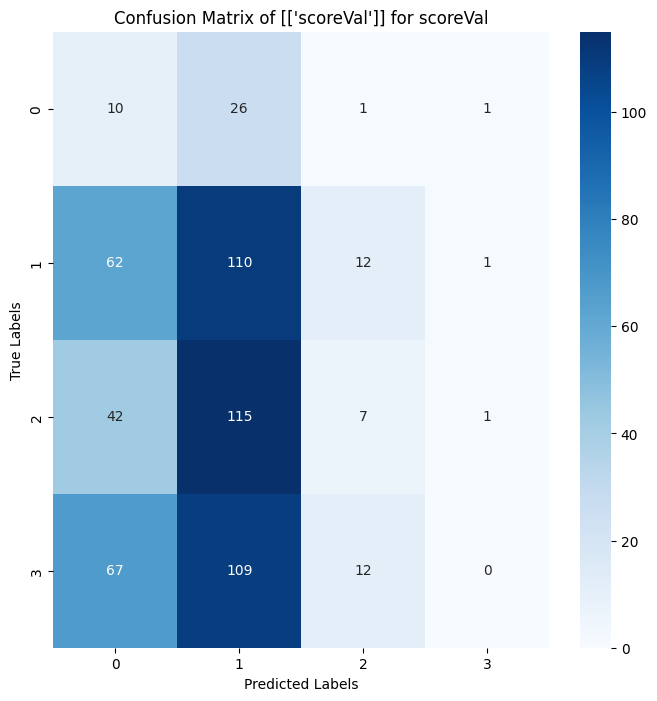

Calculating SHAP values...


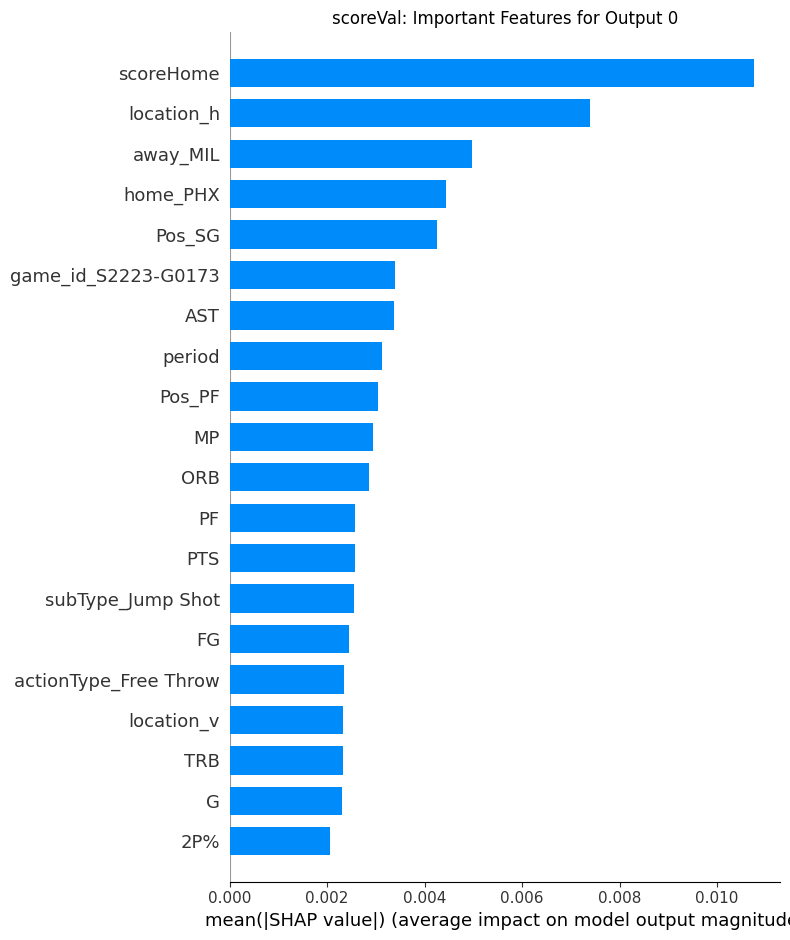

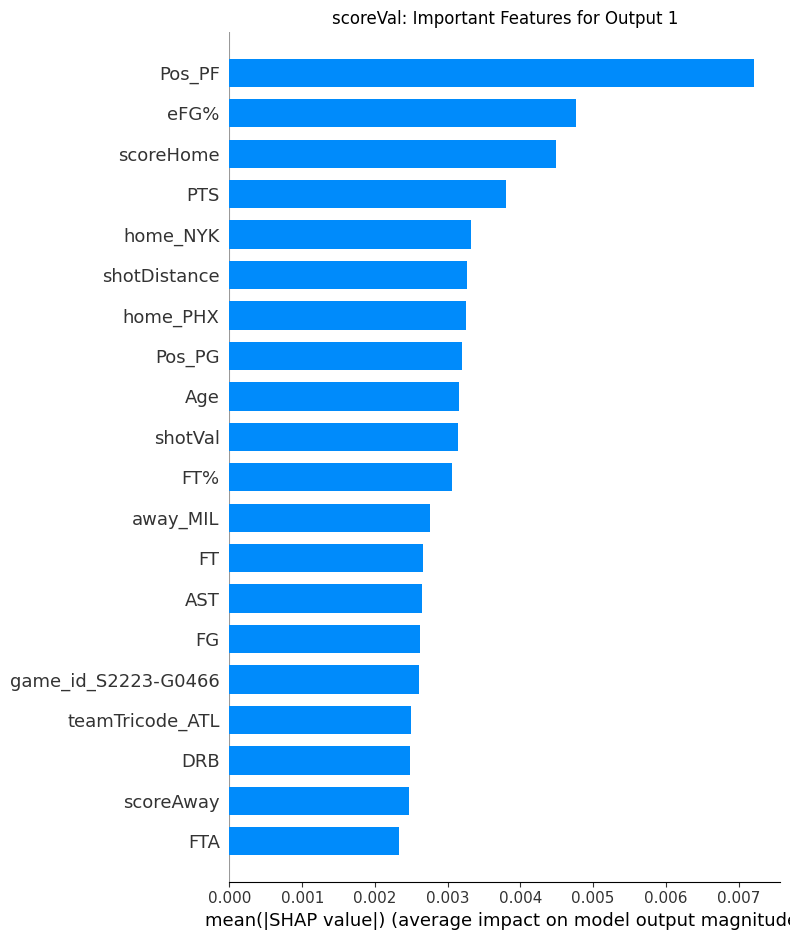

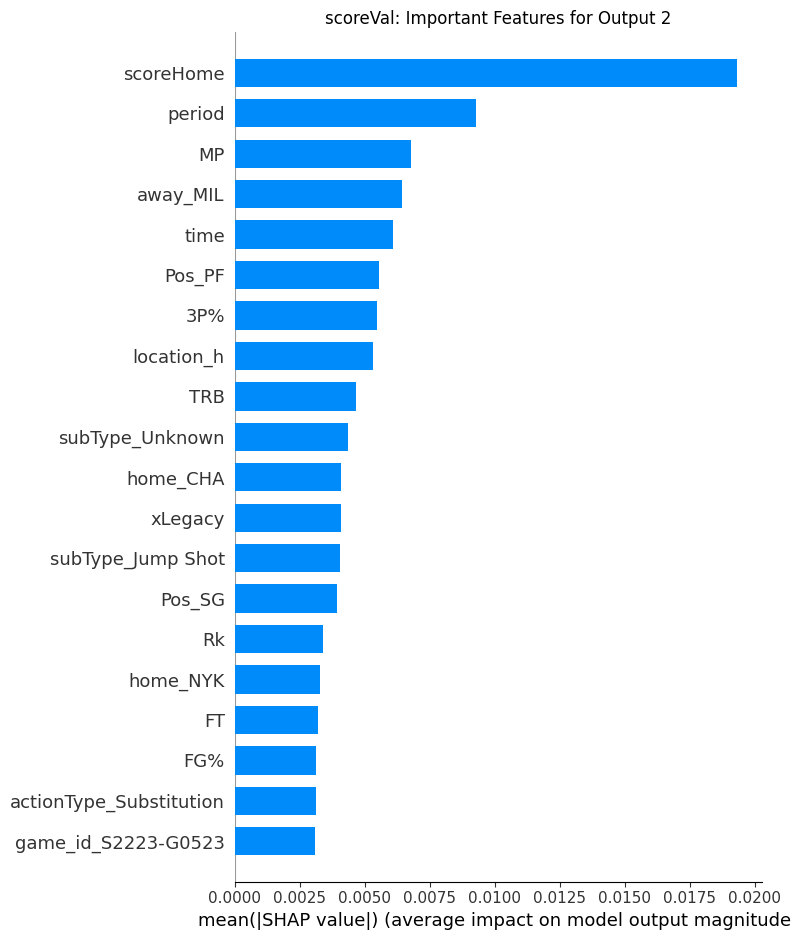

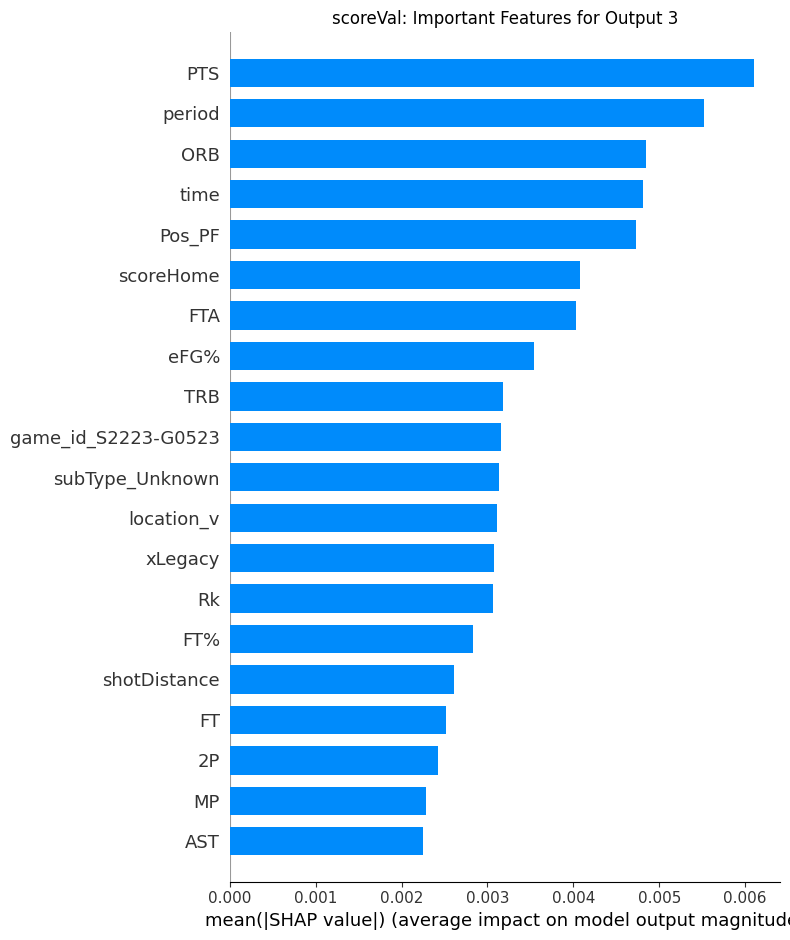

In [ ]:
printedDashLink = False
for task_type in models["tasks"]:
    for task in models["tasks"][task_type]:
        db = sqlite3.connect(task["db_path"])
        tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", db)
        for arch in models["archs"]:
            options = task | arch
            options["client"] = Client(
                n_workers=options["n_workers"], silence_logs=logging.CRITICAL
            )

            if (
                options["client"] is not None
                and not options["colab"]
                and not printedDashLink
            ):
                print(
                    f'Dask dashboard is available at {options["client"].dashboard_link}'
                )
                printedDashLink = True

            path = ""
            if "fine" in task_type:
                path = f"models/{options['task']} {options['arch']}/{options['prev']}/"
                path += f"{sorted(os.listdir(path))[-1]}/model.pt"
            trainer = Bronte(options, path)
            with joblib.parallel_backend("dask"):
                for i, table in enumerate(tables["name"].tolist()):
                    data = pd.DataFrame()

                    if options["table_prefix"] in table:
                        data = pd.read_sql(f"SELECT * FROM {table}", db)
                        if options["verbose"]:
                            print("\nSplitting data and transforming features...")

                        df = data.copy()
                        if 0 < options["sample_size"] < 1:
                            df = df.sample(frac=options["sample_size"], random_state=42)
                        if 1 <= options["sample_size"] < len(df):
                            rg = np.random.default_rng(42)
                            n = rg.choice(len(df) - 1 - int(options["sample_size"]))
                            df = df.iloc[n : n + options["sample_size"], :].copy()

                        for col in df.columns:
                            if df[col].dtype == "object":
                                try:
                                    df[col] = pd.to_numeric(df[col])
                                except ValueError:
                                    pass

                        data = pd.get_dummies(df, dtype=np.int8, sparse=True)
                        X = data.drop(columns=options["targets"])
                        y = data[options["targets"]]
                        if trainer.fit(X, y) != 0 or i >= options["samples"] - 1:
                            break

            if options["client"] is not None:
                options["client"].close()
                options["client"] = None
        db.close()

## Logs


In [ ]:
if not colab:
    !tensorboard --logdir=models

# Inference


In [ ]:
# Load X_new
# X_new = ...

# Print predictions of all trained models
# for root, dirs, files in os.walk("models"):
#    for file in files:
#        if file.endswith(".pt") and not file.split(".")[0].lstrip("-").isdigit():
#            model = Bronte(path=os.path.join(root, file)).model
#            y_new = model.predict(X_new)
#            print(f"::{model.typeof} {model.name} ({model.fits} fit(s))::\n{y_new}\n")